In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np
import sklearn.metrics as sklm
from sklearn.model_selection import train_test_split
import keras
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [3]:
from keras import backend as K

def fbeta(y_true, y_pred, threshold_shift=0, beta=1):

   # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

   # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())


In [4]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

In [5]:
class fbetaHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.fbeta_hist = []

    def on_batch_end(self, batch, logs={}):
        self.fbeta_hist.append(logs.get('fbeta'))

fbeta_history = fbetaHistory()

In [6]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.precision = []
        self.recall = []
        self.f1s = []

    def on_epoch_end(self, epoch, logs={}):
        predict = self.model.predict_classes(self.validation_data[0])
        targ = self.validation_data[1].argmax(axis=1)

        self.precision.append(sklm.precision_score(targ, predict, average='micro'))
        self.recall.append(sklm.recall_score(targ, predict, average='micro'))
        self.f1s.append(sklm.f1_score(targ, predict, average='micro'))

        return
    
metrics = Metrics()

In [7]:
wine_df = pd.read_csv('winemag_data_first150k.csv')

### Preprocessing

In [8]:
wine_df = wine_df.drop_duplicates(subset='description', keep='last')

target = wine_df['variety']
y = np.array(pd.get_dummies(target))

X_text = wine_df.description

X_text.shape, y.shape

((97821,), (97821, 632))

## BoW approach to creating our X matrix

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((88038,), (9783,), (88038, 632), (9783, 632))

In [10]:
tok = Tokenizer(filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # Keep '$' 

train_corpus = [description for description in X_train]
tok.fit_on_texts(train_corpus)

X_train = tok.texts_to_matrix(train_corpus)

test_corpus = [description for description in X_test]
X_test = tok.texts_to_matrix(test_corpus)

X_train.shape, X_test.shape

((88038, 35416), (9783, 35416))

In [11]:
model = Sequential()
# model.add(Dense(units=32, input_dim=X.shape[1], activation='relu'))
model.add(Dense(units=y_train.shape[1], input_dim=X_train.shape[1], activation='sigmoid'))
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', fbeta, precision, recall])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 632)               22383544  
Total params: 22,383,544.0
Trainable params: 22,383,544
Non-trainable params: 0.0
_________________________________________________________________


# Best 5 model

In [12]:
model.fit(X_train[:5], y_train[:5], epochs=5, batch_size=108, validation_split=.2,
          callbacks=[metrics, history, fbeta_history])

Train on 4 samples, validate on 1 samples
Epoch 1/5
4/4 [==============================] - 1s - loss: 0.6930 - acc: 0.5032 - fbeta: 0.0048 - precision: 0.0024 - recall: 0.7500 - val_loss: 0.6872 - val_acc: 0.6329 - val_fbeta: 4.3197e-10 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
4/4 [==============================] - 0s - loss: 0.6797 - acc: 0.7401 - fbeta: 0.0090 - precision: 0.0046 - recall: 0.7500 - val_loss: 0.6796 - val_acc: 0.7579 - val_fbeta: 6.5574e-10 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
4/4 [==============================] - 0s - loss: 0.6646 - acc: 0.9157 - fbeta: 0.0362 - precision: 0.0184 - recall: 1.0000 - val_loss: 0.6716 - val_acc: 0.8687 - val_fbeta: 1.2121e-09 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
4/4 [==============================] - 0s - loss: 0.6489 - acc: 0.9798 - fbeta: 0.1356 - precision: 0.0727 - recall: 1.0000 - val_loss: 0.6635 - val_acc: 0.9494 - val_fbeta: 3.1746e-09 - val_precision: 0.

In [13]:
print("Precision: ", metrics.precision)
print("mean(Precision): ", np.mean(metrics.precision))

print("Recall: ", metrics.recall)
print("mean(Recall): ", np.mean(metrics.recall))

print("F1_score: ", metrics.f1s)
print("mean(F1_score): ", np.mean(metrics.f1s))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test fbeta:', score[2])
print('Test Precision:', score[3])
print('Test Recall:', score[4])
print('Losses:', history.losses)
print('fbeta history:', fbeta_history.fbeta_hist)

Precision:  [0.0, 0.0, 0.0, 0.0, 0.0]
mean(Precision):  0.0
Recall:  [0.0, 0.0, 0.0, 0.0, 0.0]
mean(Recall):  0.0
F1_score:  [0.0, 0.0, 0.0, 0.0, 0.0]
mean(F1_score):  0.0
Test loss: 0.661421408082
Test accuracy: 0.921784700669
Test fbeta: 0.00382696900312
Test Precision: 0.00195310233401
Test Recall: 0.0950628641597
Losses: [0.6929931, 0.67972612, 0.66464877, 0.6489464, 0.63304573]
fbeta history: [0.0047543575, 0.0090497723, 0.036199089, 0.13559319, 0.57142854]


# Full Data Set

In [14]:
board = TensorBoard(log_dir='./dumb1')

In [15]:
hist = model.fit(X_train, y_train, validation_split=.2, epochs=20, batch_size=128, 
                 callbacks=[metrics, history, fbeta_history, board])

Train on 70430 samples, validate on 17608 samples
Epoch 1/20
70430/70430 [==============================] - 51s - loss: 0.0908 - acc: 0.9982 - fbeta: 0.0147 - precision: 0.3497 - recall: 0.0079 - val_loss: 0.0201 - val_acc: 0.9985 - val_fbeta: 0.0686 - val_precision: 0.9508 - val_recall: 0.0358
Epoch 2/20
70430/70430 [==============================] - 47s - loss: 0.0141 - acc: 0.9986 - fbeta: 0.1645 - precision: 0.9328 - recall: 0.0916 - val_loss: 0.0107 - val_acc: 0.9986 - val_fbeta: 0.2222 - val_precision: 0.9093 - val_recall: 0.1273
Epoch 3/20
70430/70430 [==============================] - 47s - loss: 0.0088 - acc: 0.9987 - fbeta: 0.2912 - precision: 0.9064 - recall: 0.1747 - val_loss: 0.0079 - val_acc: 0.9987 - val_fbeta: 0.3025 - val_precision: 0.8864 - val_recall: 0.1833
Epoch 4/20
70430/70430 [==============================] - 47s - loss: 0.0068 - acc: 0.9988 - fbeta: 0.3765 - precision: 0.8990 - recall: 0.2395 - val_loss: 0.0066 - val_acc: 0.9987 - val_fbeta: 0.3620 - val_preci

In [16]:
score = model.evaluate(X_test, y_test)
score

9760/9783 [============================>.] - ETA: 0s

[0.0041666213240899811,
 0.99895113564020133,
 0.55874078995511534,
 0.83039224635819942,
 0.42594296227236972]

In [17]:
np.sum(model.predict_classes(X_test)==y_test.argmax(axis=1))/X_test.shape[0]

9728/9783 [============================>.] - ETA: 0s

0.60768680363896554

In [18]:
print("Precision: ", metrics.precision)
print("mean(Precision): ", np.mean(metrics.precision))

print("Recall: ", metrics.recall)
print("mean(Recall): ", np.mean(metrics.recall))

print("F1_score: ", metrics.f1s)
print("mean(F1_score): ", np.mean(metrics.f1s))

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test fbeta:', score[2])
print('Test Precision:', score[3])
print('Test Recall:', score[4])
# print('Losses:', history.losses)
# print('fbeta history:', fbeta_history.fbeta_hist)

Precision:  [0.37426169922762381, 0.44701272149023169, 0.50249886415265788, 0.53271240345297588, 0.55111313039527488, 0.56559518400726938, 0.57388686960472512, 0.58144025442980463, 0.58808496138119037, 0.59421853702862337, 0.59614947751022263, 0.59859154929577463, 0.60057928214447975, 0.60222626079054975, 0.60256701499318488, 0.60302135393003176, 0.6027373920945025, 0.60120399818264425, 0.60154475238527938, 0.60040890504316224]
mean(Precision):  0.565992730577
Recall:  [0.37426169922762381, 0.44701272149023169, 0.50249886415265788, 0.53271240345297588, 0.55111313039527488, 0.56559518400726938, 0.57388686960472512, 0.58144025442980463, 0.58808496138119037, 0.59421853702862337, 0.59614947751022263, 0.59859154929577463, 0.60057928214447975, 0.60222626079054975, 0.60256701499318488, 0.60302135393003176, 0.6027373920945025, 0.60120399818264425, 0.60154475238527938, 0.60040890504316224]
mean(Recall):  0.565992730577
F1_score:  [0.37426169922762387, 0.44701272149023169, 0.50249886415265788, 0

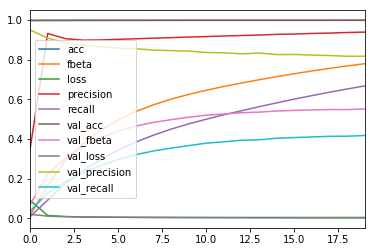

In [19]:
pd.DataFrame(hist.history).plot();

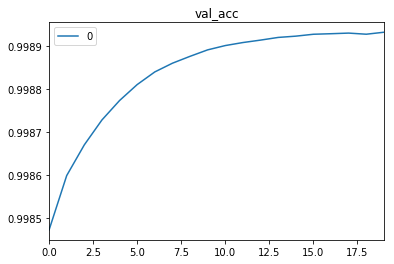

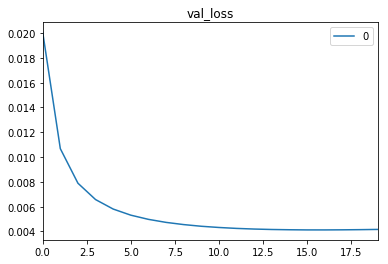

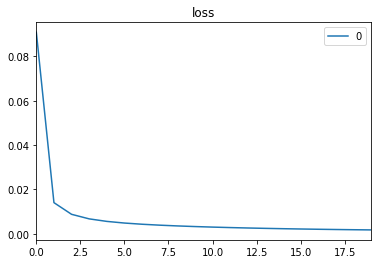

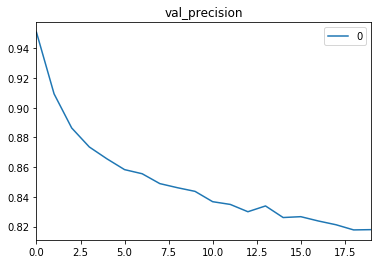

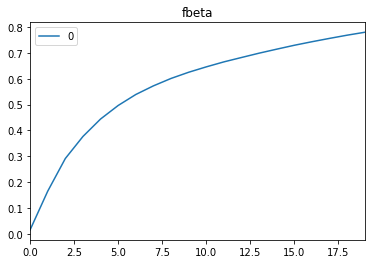

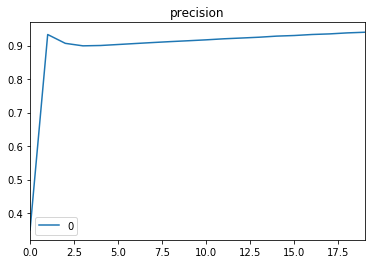

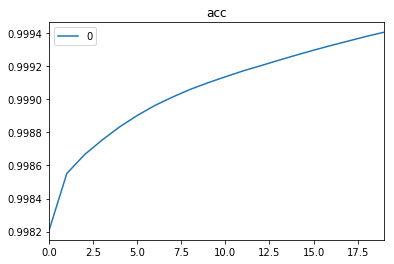

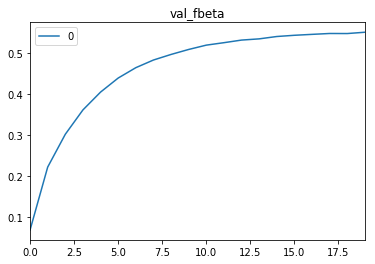

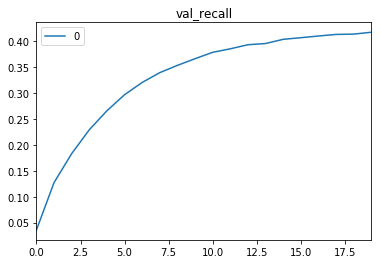

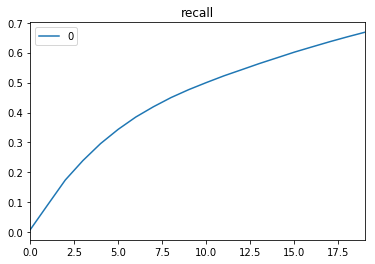

In [20]:
a = [k for k,v in hist.history.items()]
for ky in a:
    pd.DataFrame(hist.history[ky]).plot(title=ky);

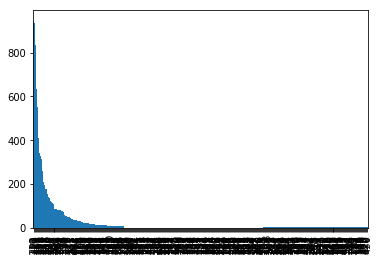

In [21]:
pd.Series(y_test.argmax(axis=1)).value_counts().plot(kind='bar');

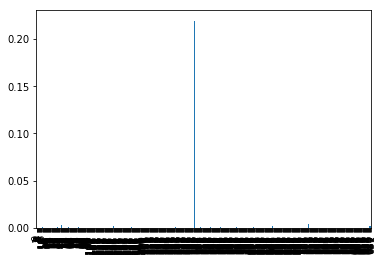

In [22]:
pd.Series(model.predict(X_test[:1])[0]).plot(kind='bar');

___